# DATA EXPLORATION

In [2]:
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from flask import Flask, jsonify, request

In [2]:
titlesize = 16
labelsize = 16
legendsize = 16
xticksize = 16
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

In [78]:
PATH_DF_USERS = "data/df_users.csv"
PATH_DF_SALES = "data/df_sales.csv"

# EMB_PATH_KNRM = os.environ['PATH_DF_USERS']
# VOCAB_PATH = os.environ['PATH_DF_SALES']

# Get data about users and their purchases
df_users = pd.read_csv(PATH_DF_USERS)
df_sales = pd.read_csv(PATH_DF_SALES)

## USERS

In [4]:
df_users

,user_id,gender,age
0,2661066,0,22
1,3848565,1,29
2,5801450,0,24
3,1041736,0,27
4,9545654,1,25
...,...,...,...
999995,6230586,0,23
999996,6168079,1,25
999997,8134126,0,30
999998,8975579,1,25


In [5]:
df_users.stb.missing()

,missing,total,percent
user_id,0,1000000,0.0
gender,0,1000000,0.0
age,0,1000000,0.0


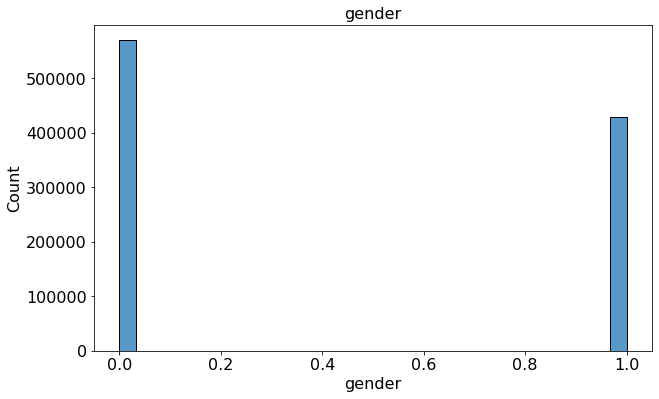

In [6]:
sns.histplot(df_users['gender'], bins=30)
plt.title('gender')
plt.show()

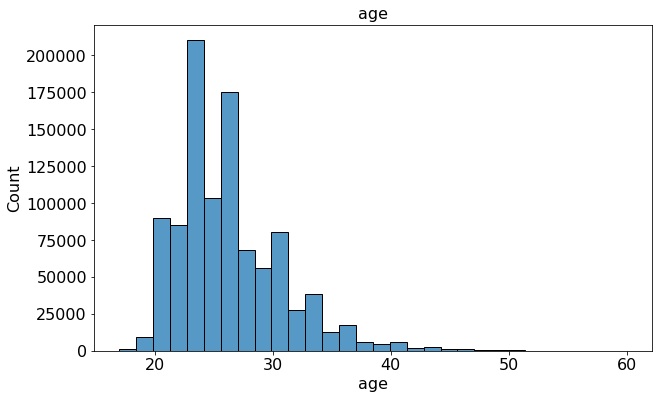

In [7]:
sns.histplot(df_users['age'], bins=30)
plt.title('age')
plt.show()

In [1]:
df_users['age'].value_counts().sort_index(ascending=True)

## SALES

In [9]:
df_sales

,user_id,day,sales
0,2661066,0,397
1,3848565,1,841
2,3848565,2,423
3,3848565,4,826
4,3848565,6,859
...,...,...,...
39530484,1403724,52,358
39530485,1403724,52,169
39530486,1403724,52,140
39530487,1403724,53,614


In [10]:
df_sales.stb.missing()

,missing,total,percent
user_id,0,39530489,0.0
day,0,39530489,0.0
sales,0,39530489,0.0


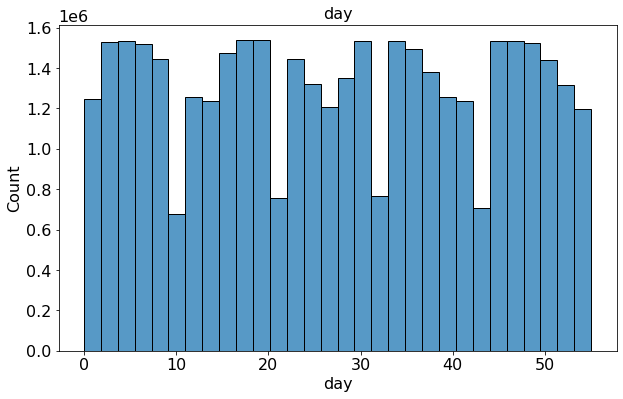

In [11]:
sns.histplot(df_sales['day'], bins=30)
plt.title('day')
plt.show()

In [80]:
# import plotly.express as px
# fig = px.histogram(df_sales, x="day", nbins=30)
# fig.show()

In [2]:
df_sales['day'].value_counts().sort_index(ascending=True)

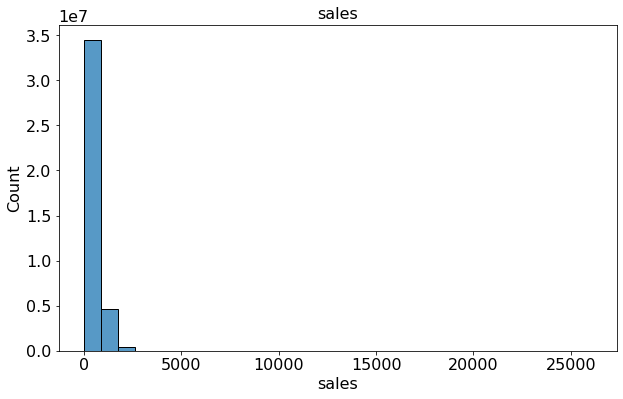

In [13]:
sns.histplot(df_sales['sales'], bins=30)
plt.title('sales')
plt.show()

In [14]:
df_sales['sales'].value_counts().sort_index(ascending=True)

0        496
1        529
2        533
3        553
4        592
        ... 
25611      1
25630      1
25640      1
25659      1
26047      1
Name: sales, Length: 8574, dtype: int64

In [15]:
df_sales['sales'].quantile(0.99)

1755.0

LET'S DELETE OUTLIERS

In [17]:
df_sales = df_sales.loc[(df_sales['sales'] > 0) & (df_sales['sales'] <= 2000), :]

## AGG

In [19]:
df_full = df_users.merge(df_sales, on=['user_id'], how='left')

In [20]:
df_full.stb.missing()

,missing,total,percent
day,624,39335008,0.001586
sales,624,39335008,0.001586
user_id,0,39335008,0.000000
gender,0,39335008,0.000000
age,0,39335008,0.000000


In [21]:
df_full.head()

,user_id,gender,age,day,sales
0,2661066,0,22,0.0,397.0
1,3848565,1,29,1.0,841.0
2,3848565,1,29,2.0,423.0
3,3848565,1,29,4.0,826.0
4,3848565,1,29,6.0,859.0


In [33]:
df_full = df_full.fillna(0)

In [34]:
bins = [0, 6, 13, 20, 27, 35, 42, 49, 56]
df_full['bins'] = pd.cut(df_full['day'], bins, right=True)

### SEARCH STRATS WITH WEEKS

In [36]:
df_full_agg = df_full.groupby(['gender', 'age', 'bins'])['sales'].sum().reset_index()

<AxesSubplot:xlabel='age', ylabel='sales'>

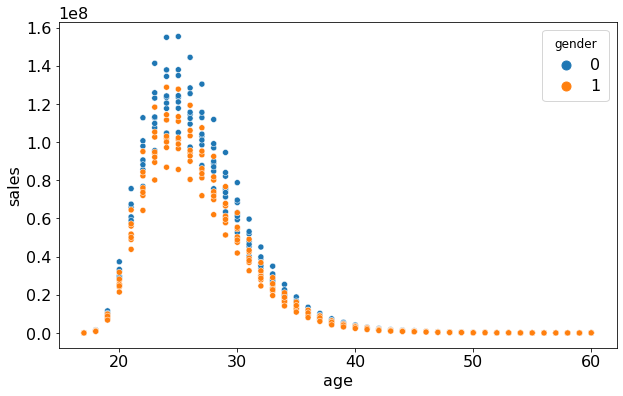

In [37]:
sns.scatterplot(data=df_full_agg, x="age", y="sales", hue="gender")

In [4]:
import plotly.express as px
fig = px.scatter(df_full_agg, x="age", y="sales", color="gender", #size='',
                  hover_data=['gender'])
fig.show()

### SEARCH STRATS WITHOUT WEEKS

In [45]:
df_full_agg = df_full.groupby(['gender', 'age'])['sales'].sum().reset_index()

In [46]:
df_full_agg.head()

,gender,age,sales
0,0,17,113478.0
1,0,18,10612500.0
2,0,19,76778347.0
3,0,20,247470183.0
4,0,21,503173306.0


<AxesSubplot:xlabel='age', ylabel='sales'>

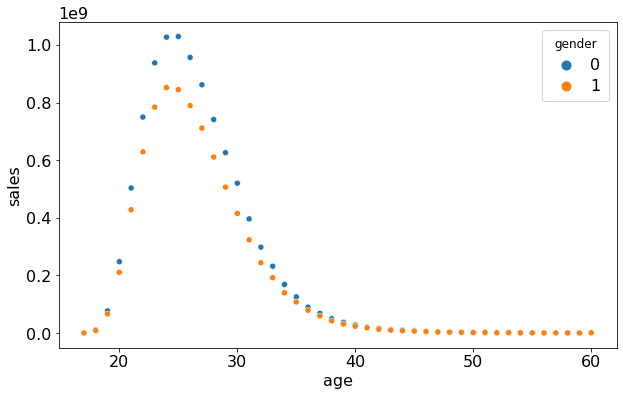

In [47]:
sns.scatterplot(data=df_full_agg, x="age", y="sales", hue="gender")

In [3]:
import plotly.express as px
fig = px.scatter(df_full_agg, x="age", y="sales", color="gender", #size='',
                  hover_data=['gender'])
fig.show()

STRATS: <br>
gender 0, age <= 25; <br>
gender 1, age <= 25; <br>
gender 0, age > 25; <br>
gender 1, age > 25; <br>

# DATA PREPARATIONS

In [3]:
PATH_DF_USERS = "data/df_users.csv"
PATH_DF_SALES = "data/df_sales.csv"

# EMB_PATH_KNRM = os.environ['PATH_DF_USERS']
# VOCAB_PATH = os.environ['PATH_DF_SALES']

# Get data about users and their purchases
df_users = pd.read_csv(PATH_DF_USERS)
df_sales = pd.read_csv(PATH_DF_SALES)

In [4]:
df_sales = df_sales.loc[(df_sales['sales'] > 0) & (df_sales['sales'] <= 2000), :]
df_sales = df_sales.loc[df_sales['day'] >= 21, :]

<pre>
gender;  age;   2 * age;   sum(gender + 2 * age); <br>
0        0      0          0 <br>
0        1      2          2 <br>
1        0      0          1 <br>
1        1      2          3 <br>
</pre>

In [6]:
df_users['stratum'] = (df_users['gender'] + (df_users['age'] > 25).astype(int) * 2).astype(int)
strats_weights = df_users['stratum'].value_counts() / len(df_users['stratum'])

In [18]:
df_sales_prepilot_agg = (df_sales.loc[df_sales['day'].isin(np.arange(21, 49))]
                         .groupby(['user_id'])['sales'].sum().reset_index()
                         .rename(columns={'sales':'sales_prepilot'})
                         )

In [19]:
df_sales_pilot_agg = (df_sales.loc[df_sales['day'].isin(np.arange(49, 56))]
                         .groupby(['user_id'])['sales'].sum().reset_index()
                         .rename(columns={'sales':'sales_pilot'})
                        )

In [23]:
df_final = pd.DataFrame({'user_id': df_sales['user_id'].unique()})
df_final = df_final.merge(df_sales_prepilot_agg, on=['user_id'], how='left').fillna(0)
df_final = df_final.merge(df_sales_pilot_agg, on=['user_id'], how='left').fillna(0)

In [25]:
# CALC THETA
cov_val = df_final['sales_prepilot'].values
target_val = df_final['sales_pilot'].values
covariance = np.cov(cov_val, target_val)[0, 1]
variance = cov_val.var()
theta = covariance / variance

In [26]:
df_final['sales_cuped'] = df_final['sales_pilot'] - theta * df_final['sales_prepilot']

# GATHERING ALL TOGETHER

In [1]:
import os
import json
import time
import gc

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from flask import Flask, jsonify, request

PATH_DF_USERS = "data/df_users.csv"
PATH_DF_SALES = "data/df_sales.csv"

# PATH_DF_USERS = os.environ['PATH_DF_USERS']
# PATH_DF_SALES = os.environ['PATH_DF_SALES']

df_users = pd.read_csv(PATH_DF_USERS)
df_sales = pd.read_csv(PATH_DF_SALES)

# USERS
df_users['stratum'] = (df_users['gender'] + (df_users['age'] > 25).astype(int) * 2).astype(int)
strats_weights = df_users['stratum'].value_counts() / len(df_users['stratum'])

# SALES
df_sales = df_sales.loc[(df_sales['sales'] > 0) & (df_sales['sales'] <= 2000), :]
df_sales = df_sales.loc[df_sales['day'] >= 21, :]

df_sales_prepilot_agg = (df_sales.loc[df_sales['day'].isin(np.arange(21, 21+28))]
                         .groupby(['user_id'])['sales'].sum().reset_index()
                         .rename(columns={'sales':'sales_prepilot'})
                         )

df_sales_pilot_agg = (df_sales.loc[df_sales['day'].isin(np.arange(49, 56))]
                         .groupby(['user_id'])['sales'].sum().reset_index()
                         .rename(columns={'sales':'sales_pilot'})
                      )

# FINAL SALES DF
df_final_sales = pd.DataFrame({'user_id': df_sales['user_id'].unique()})
del df_sales
df_final_sales = df_final_sales.merge(df_sales_prepilot_agg, on=['user_id'], how='left').fillna(0)
df_final_sales = df_final_sales.merge(df_sales_pilot_agg, on=['user_id'], how='left').fillna(0)

# CALC THETA
cov_val = df_final_sales['sales_prepilot'].values
target_val = df_final_sales['sales_pilot'].values
covariance = np.cov(cov_val, target_val)[0, 1]
variance = cov_val.var()
theta = covariance / variance

# CUPED SALES
df_final_sales['sales_cuped'] = df_final_sales['sales_pilot'] - theta * df_final_sales['sales_prepilot']
del df_sales_prepilot_agg, df_sales_pilot_agg, cov_val, target_val, covariance, variance, theta

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [20]:
app = Flask(__name__)

@app.route('/ping')
def ping():
    return jsonify(status='ok')

def _check_test(test):
    
    def _calc_strat_values(df, strats, weights):
        mean_strats = df.groupby(['stratum'])['sales_cuped'].mean()
        mean = (mean_strats * weights).sum()
        var_strats = df.groupby(['stratum'])['sales_cuped'].var()
        var = (var_strats * weights).sum()
        return mean, var

    def _check_calc(df_a, df_b, strats, weights):
        mean_control, var_control = _calc_strat_values(df_a, strats, weights)
        mean_pilot, var_pilot = _calc_strat_values(df_b, strats, weights)
        
        delta_mean = mean_pilot - mean_control
        std_mean = (var_control / len(df_a) + var_pilot / len(df_b)) ** 0.5
        
        left_bound = delta_mean - 1.96 * std_mean
        right_bound = delta_mean + 1.96 * std_mean

        return int(left_bound > 0)

    # MAKING DFS FROM USERS IDS
    group_a_one = test['group_a_one']
    group_a_two = test['group_a_two']
    group_b = test['group_b']
    all_user_ids = group_a_one + group_a_two + group_b
    
    df_full = (df_users.loc[df_users['user_id'].isin(all_user_ids), :]
                 .merge(df_final_sales.loc[df_final_sales['user_id'].isin(all_user_ids), 
                                           ['user_id', 'sales_cuped']], on=['user_id'], how='left')
                )
    
    df_full_a_one = df_full.loc[df_full['user_id'].isin(group_a_one), :]
    
    df_full_a_two = df_full.loc[df_full['user_id'].isin(group_a_two), :]
    
    df_full_b = df_full.loc[df_full['user_id'].isin(group_b), :]
    
    # CHECKING THAT ALL GROUPS HAVE THE SAME STRATS
    strats_a_one = set(df_full_a_one['stratum'].unique())
    strats_a_two = set(df_full_a_two['stratum'].unique())
    strats_b = set(df_full_b['stratum'].unique())
    if (strats_a_one == strats_a_two == strats_b) and len(strats_a_one) > 1: 
        pass 
    else:
        return 0
    
    # CALC NEW STRAT WEIGHTS
    curr_types_strats = list(strats_a_one)
    curr_strats_weights = strats_weights.loc[curr_types_strats] / strats_weights.loc[curr_types_strats].sum()
    
    # AA
    if _check_calc(df_full_a_one, df_full_a_two, curr_types_strats, curr_strats_weights):
        return 0
    
    ## AB
    return _check_calc(pd.concat([df_full_a_one, df_full_a_two], ignore_index=True, axis=0), 
                       df_full_b, curr_types_strats, curr_strats_weights)

@app.route('/check_test', methods=['POST'])
def check_test():
    test = request.json['test']
    has_effect = _check_test(test)
    return jsonify(has_effect=int(has_effect))

from werkzeug.middleware.proxy_fix import ProxyFix
app.wsgi_app = ProxyFix(app.wsgi_app)
app.run(debug=False, host="127.0.0.1", port=11000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:11000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Aug/2022 16:19:31] "GET /ping HTTP/1.1" 200 -
127.0.0.1 - - [19/Aug/2022 16:19:31] "POST /check_test HTTP/1.1" 200 -


In [19]:
# USE FILE checking_connection or THIS

req = {'test': {'group_a_one': [6704461, 8415475, 5341240], 
                    'group_a_two': [7948400, 9442928, 7249197], 
                    'group_b': [7095673, 2204967, 9142264]}}
test = req['test']
_check_test(test)

0